# Method 7 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

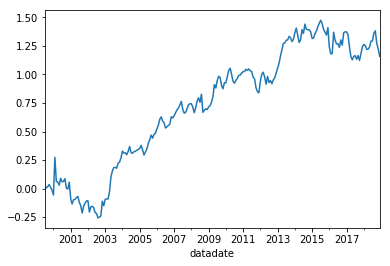

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.014404
2000-12-31    0.071745
2001-12-31   -0.156330
2002-12-31   -0.047249
2003-12-31    0.494315
2004-12-31    0.059436
2005-12-31    0.105839
2006-12-31    0.089620
2007-12-31    0.076509
2008-12-31   -0.029647
2009-12-31    0.139434
2010-12-31    0.043685
2011-12-31   -0.085852
2012-12-31    0.093668
2013-12-31    0.146834
2014-12-31    0.029056
2015-12-31    0.015652
2016-12-31   -0.015618
2017-12-31   -0.054857
2018-12-31   -0.037251
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     28.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-19
Time:                        21:21:16   Log-Likelihood:                 463.49
No. Observations:                 234   AIC:                            -917.0
Df Residuals:                     229   BIC:                            -899.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.472      0.142      -0.001       0.008
mktrf          0.0316      0.063      0.502      0.616      -0.092       0.156
me             0.5011      0.073      6.844      0.000       0.357       0.645
ia            -0.0156      0.111     -0.140      0.889      -0.235       0.204
roe           -0.3706      0.095     -3.891      0.000      -0.558      -0.183
==============================================================================
Omnibus:                       61.146   Durbin-Watson:                   2.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1224.607
Skew:                           0.333   Prob(JB):                    1.20e-266
Kurtosis:                      14.187   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     8.415
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-06
Time:                        21:21:16   Log-Likelihood:                 463.49
No. Observations:                 234   AIC:                            -917.0
Df Residuals:                     229   BIC:                            -899.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.003      1.212      0.225      -0.002       0.009
mktrf          0.0316      0.083      0.380      0.704      -0.131       0.194
me             0.5011      0.216      2.321      0.020       0.078       0.924
ia            -0.0156      0.225     -0.069      0.945      -0.457       0.426
roe           -0.3706      0.215     -1.722      0.085      -0.792       0.051
==============================================================================
Omnibus:                       61.146   Durbin-Watson:                   2.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1224.607
Skew:                           0.333   Prob(JB):                    1.20e-266
Kurtosis:                      14.187   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     10.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.37e-08
Time:                        21:21:16   Log-Likelihood:                 463.49
No. Observations:                 234   AIC:                            -917.0
Df Residuals:                     229   BIC:                            -899.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.003      1.108      0.268      -0.003       0.009
mktrf          0.0316      0.065      0.483      0.629      -0.097       0.160
me             0.5011      0.227      2.209      0.027       0.056       0.946
ia            -0.0156      0.172     -0.090      0.928      -0.353       0.322
roe           -0.3706      0.238     -1.560      0.119      -0.836       0.095
==============================================================================
Omnibus:                       61.146   Durbin-Watson:                   2.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1224.607
Skew:                           0.333   Prob(JB):                    1.20e-266
Kurtosis:                      14.187   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     34.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.47e-26
Time:                        21:21:16   Log-Likelihood:                 481.51
No. Observations:                 234   AIC:                            -951.0
Df Residuals:                     228   BIC:                            -930.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.050      0.041       0.000       0.009
mktrf          0.0418      0.059      0.715      0.476      -0.073       0.157
smb            0.3324      0.077      4.305      0.000       0.180       0.485
hml           -0.1533      0.091     -1.683      0.094      -0.333       0.026
rmw           -0.6407      0.103     -6.224      0.000      -0.844      -0.438
cma            0.4472      0.131      3.418      0.001       0.189       0.705
==============================================================================
Omnibus:                       48.428   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              645.068
Skew:                          -0.181   Prob(JB):                    8.42e-141
Kurtosis:                      11.126   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     20.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.99e-17
Time:                        21:21:16   Log-Likelihood:                 481.51
No. Observations:                 234   AIC:                            -951.0
Df Residuals:                     228   BIC:                            -930.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.332      0.020       0.001       0.008
mktrf          0.0418      0.065      0.647      0.518      -0.085       0.168
smb            0.3324      0.101      3.302      0.001       0.135       0.530
hml           -0.1533      0.121     -1.263      0.206      -0.391       0.084
rmw           -0.6407      0.147     -4.363      0.000      -0.928      -0.353
cma            0.4472      0.235      1.902      0.057      -0.014       0.908
==============================================================================
Omnibus:                       48.428   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              645.068
Skew:                          -0.181   Prob(JB):                    8.42e-141
Kurtosis:                      11.126   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     25.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.01e-20
Time:                        21:21:16   Log-Likelihood:                 481.51
No. Observations:                 234   AIC:                            -951.0
Df Residuals:                     228   BIC:                            -930.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.307      0.021       0.001       0.008
mktrf          0.0418      0.062      0.674      0.500      -0.080       0.163
smb            0.3324      0.089      3.716      0.000       0.157       0.508
hml           -0.1533      0.119     -1.286      0.199      -0.387       0.080
rmw           -0.6407      0.149     -4.292      0.000      -0.933      -0.348
cma            0.4472      0.193      2.311      0.021       0.068       0.826
==============================================================================
Omnibus:                       48.428   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              645.068
Skew:                          -0.181   Prob(JB):                    8.42e-141
Kurtosis:                      11.126   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     26.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.23e-18
Time:                        21:21:16   Log-Likelihood:                 459.78
No. Observations:                 234   AIC:                            -909.6
Df Residuals:                     229   BIC:                            -892.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.799      0.425      -0.003       0.006
mktrf          0.1690      0.059      2.871      0.004       0.053       0.285
smb            0.5716      0.073      7.778      0.000       0.427       0.716
hml           -0.0650      0.073     -0.890      0.375      -0.209       0.079
umd            0.0232      0.048      0.484      0.629      -0.071       0.118
==============================================================================
Omnibus:                       62.864   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              928.665
Skew:                           0.532   Prob(JB):                    2.20e-202
Kurtosis:                      12.701   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     15.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.15e-11
Time:                        21:21:16   Log-Likelihood:                 459.78
No. Observations:                 234   AIC:                            -909.6
Df Residuals:                     229   BIC:                            -892.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.795      0.427      -0.003       0.006
mktrf          0.1690      0.066      2.571      0.010       0.040       0.298
smb            0.5716      0.173      3.311      0.001       0.233       0.910
hml           -0.0650      0.113     -0.574      0.566      -0.287       0.157
umd            0.0232      0.113      0.205      0.838      -0.199       0.245
==============================================================================
Omnibus:                       62.864   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              928.665
Skew:                           0.532   Prob(JB):                    2.20e-202
Kurtosis:                      12.701   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     17.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.01e-12
Time:                        21:21:16   Log-Likelihood:                 459.78
No. Observations:                 234   AIC:                            -909.6
Df Residuals:                     229   BIC:                            -892.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.736      0.462      -0.003       0.007
mktrf          0.1690      0.058      2.895      0.004       0.055       0.283
smb            0.5716      0.140      4.098      0.000       0.298       0.845
hml           -0.0650      0.113     -0.574      0.566      -0.287       0.157
umd            0.0232      0.117      0.198      0.843      -0.207       0.253
==============================================================================
Omnibus:                       62.864   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              928.665
Skew:                           0.532   Prob(JB):                    2.20e-202
Kurtosis:                      12.701   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     15.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.62e-10
Time:                        21:21:16   Log-Likelihood:                 209.72
No. Observations:                 120   AIC:                            -409.4
Df Residuals:                     115   BIC:                            -395.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      0.975      0.332      -0.004       0.012
mktrf          0.0611      0.111      0.550      0.583      -0.159       0.281
me             0.6109      0.110      5.573      0.000       0.394       0.828
ia            -0.0139      0.172     -0.081      0.936      -0.354       0.326
roe           -0.2928      0.152     -1.928      0.056      -0.594       0.008
==============================================================================
Omnibus:                       23.559   Durbin-Watson:                   2.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.914
Skew:                           0.071   Prob(JB):                     3.45e-37
Kurtosis:                       8.793   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     5.245
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000646
Time:                        21:21:16   Log-Likelihood:                 209.72
No. Observations:                 120   AIC:                            -409.4
Df Residuals:                     115   BIC:                            -395.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.005      0.758      0.449      -0.006       0.014
mktrf          0.0611      0.137      0.446      0.656      -0.208       0.330
me             0.6109      0.266      2.299      0.021       0.090       1.132
ia            -0.0139      0.302     -0.046      0.963      -0.607       0.579
roe           -0.2928      0.309     -0.949      0.343      -0.898       0.312
==============================================================================
Omnibus:                       23.559   Durbin-Watson:                   2.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.914
Skew:                           0.071   Prob(JB):                     3.45e-37
Kurtosis:                       8.793   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     8.490
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.88e-06
Time:                        21:21:16   Log-Likelihood:                 209.72
No. Observations:                 120   AIC:                            -409.4
Df Residuals:                     115   BIC:                            -395.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.006      0.666      0.505      -0.008       0.016
mktrf          0.0611      0.116      0.527      0.598      -0.166       0.288
me             0.6109      0.284      2.148      0.032       0.053       1.168
ia            -0.0139      0.247     -0.056      0.955      -0.498       0.470
roe           -0.2928      0.345     -0.849      0.396      -0.969       0.383
==============================================================================
Omnibus:                       23.559   Durbin-Watson:                   2.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.914
Skew:                           0.071   Prob(JB):                     3.45e-37
Kurtosis:                       8.793   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     20.58
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-14
Time:                        21:21:16   Log-Likelihood:                 222.09
No. Observations:                 120   AIC:                            -432.2
Df Residuals:                     114   BIC:                            -415.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.004      1.864      0.065      -0.000       0.015
mktrf          0.0256      0.106      0.241      0.810      -0.184       0.236
smb            0.3653      0.120      3.042      0.003       0.127       0.603
hml           -0.1639      0.147     -1.114      0.268      -0.455       0.128
rmw           -0.6824      0.174     -3.933      0.000      -1.026      -0.339
cma            0.5398      0.190      2.840      0.005       0.163       0.916
==============================================================================
Omnibus:                       28.205   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.172
Skew:                          -0.542   Prob(JB):                     5.48e-34
Kurtosis:                       8.428   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     27.47
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.68e-18
Time:                        21:21:16   Log-Likelihood:                 222.09
No. Observations:                 120   AIC:                            -432.2
Df Residuals:                     114   BIC:                            -415.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.003      2.169      0.030       0.001       0.014
mktrf          0.0256      0.102      0.250      0.803      -0.175       0.226
smb            0.3653      0.129      2.839      0.005       0.113       0.617
hml           -0.1639      0.209     -0.784      0.433      -0.574       0.246
rmw           -0.6824      0.227     -3.001      0.003      -1.128      -0.237
cma            0.5398      0.300      1.801      0.072      -0.048       1.127
==============================================================================
Omnibus:                       28.205   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.172
Skew:                          -0.542   Prob(JB):                     5.48e-34
Kurtosis:                       8.428   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     54.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.94e-29
Time:                        21:21:16   Log-Likelihood:                 222.09
No. Observations:                 120   AIC:                            -432.2
Df Residuals:                     114   BIC:                            -415.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.003      2.069      0.039       0.000       0.014
mktrf          0.0256      0.094      0.272      0.785      -0.159       0.210
smb            0.3653      0.116      3.154      0.002       0.138       0.592
hml           -0.1639      0.208     -0.788      0.431      -0.572       0.244
rmw           -0.6824      0.240     -2.840      0.005      -1.153      -0.212
cma            0.5398      0.225      2.398      0.017       0.099       0.981
==============================================================================
Omnibus:                       28.205   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.172
Skew:                          -0.542   Prob(JB):                     5.48e-34
Kurtosis:                       8.428   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     16.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-10
Time:                        21:21:16   Log-Likelihood:                 210.35
No. Observations:                 120   AIC:                            -410.7
Df Residuals:                     115   BIC:                            -396.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.002      0.318      -0.004       0.012
mktrf          0.1923      0.097      1.978      0.050      -0.000       0.385
smb            0.6400      0.111      5.780      0.000       0.421       0.859
hml           -0.0891      0.111     -0.803      0.423      -0.309       0.131
umd            0.0302      0.068      0.442      0.660      -0.105       0.166
==============================================================================
Omnibus:                       24.069   Durbin-Watson:                   2.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.361
Skew:                           0.095   Prob(JB):                     5.05e-39
Kurtosis:                       8.936   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     15.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.66e-10
Time:                        21:21:16   Log-Likelihood:                 210.35
No. Observations:                 120   AIC:                            -410.7
Df Residuals:                     115   BIC:                            -396.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.018      0.309      -0.004       0.012
mktrf          0.1923      0.102      1.894      0.058      -0.007       0.391
smb            0.6400      0.206      3.109      0.002       0.236       1.044
hml           -0.0891      0.159     -0.559      0.576      -0.401       0.223
umd            0.0302      0.136      0.221      0.825      -0.237       0.297
==============================================================================
Omnibus:                       24.069   Durbin-Watson:                   2.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.361
Skew:                           0.095   Prob(JB):                     5.05e-39
Kurtosis:                       8.936   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     25.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-15
Time:                        21:21:17   Log-Likelihood:                 210.35
No. Observations:                 120   AIC:                            -410.7
Df Residuals:                     115   BIC:                            -396.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      0.912      0.362      -0.005       0.013
mktrf          0.1923      0.089      2.156      0.031       0.017       0.367
smb            0.6400      0.164      3.914      0.000       0.320       0.961
hml           -0.0891      0.175     -0.510      0.610      -0.431       0.253
umd            0.0302      0.132      0.229      0.819      -0.229       0.289
==============================================================================
Omnibus:                       24.069   Durbin-Watson:                   2.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.361
Skew:                           0.095   Prob(JB):                     5.05e-39
Kurtosis:                       8.936   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     16.85
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.76e-11
Time:                        21:21:17   Log-Likelihood:                 294.90
No. Observations:                 114   AIC:                            -579.8
Df Residuals:                     109   BIC:                            -566.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.766      0.445      -0.002       0.005
mktrf          0.1090      0.055      1.991      0.049       0.001       0.218
me             0.1257      0.085      1.488      0.140      -0.042       0.293
ia            -0.0482      0.117     -0.411      0.682      -0.281       0.184
roe           -0.5632      0.103     -5.467      0.000      -0.767      -0.359
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.220
Skew:                           0.106   Prob(JB):                        0.896
Kurtosis:                       3.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     18.15
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.89e-11
Time:                        21:21:17   Log-Likelihood:                 294.90
No. Observations:                 114   AIC:                            -579.8
Df Residuals:                     109   BIC:                            -566.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.057      0.290      -0.001       0.004
mktrf          0.1090      0.049      2.236      0.025       0.013       0.205
me             0.1257      0.051      2.458      0.014       0.025       0.226
ia            -0.0482      0.155     -0.310      0.757      -0.353       0.256
roe           -0.5632      0.140     -4.034      0.000      -0.837      -0.290
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.220
Skew:                           0.106   Prob(JB):                        0.896
Kurtosis:                       3.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     26.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.20e-15
Time:                        21:21:17   Log-Likelihood:                 294.90
No. Observations:                 114   AIC:                            -579.8
Df Residuals:                     109   BIC:                            -566.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      0.997      0.319      -0.001       0.004
mktrf          0.1090      0.049      2.229      0.026       0.013       0.205
me             0.1257      0.038      3.353      0.001       0.052       0.199
ia            -0.0482      0.165     -0.292      0.771      -0.372       0.275
roe           -0.5632      0.119     -4.730      0.000      -0.797      -0.330
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.220
Skew:                           0.106   Prob(JB):                        0.896
Kurtosis:                       3.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     10.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-08
Time:                        21:21:17   Log-Likelihood:                 290.24
No. Observations:                 114   AIC:                            -568.5
Df Residuals:                     108   BIC:                            -552.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.308      0.758      -0.003       0.004
mktrf          0.1386      0.055      2.536      0.013       0.030       0.247
smb            0.1410      0.089      1.589      0.115      -0.035       0.317
hml            0.0492      0.113      0.435      0.664      -0.175       0.274
rmw           -0.5339      0.139     -3.854      0.000      -0.809      -0.259
cma           -0.0337      0.176     -0.192      0.848      -0.382       0.315
==============================================================================
Omnibus:                        7.967   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               15.170
Skew:                          -0.125   Prob(JB):                     0.000508
Kurtosis:                       4.770   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     6.721
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.73e-05
Time:                        21:21:17   Log-Likelihood:                 290.24
No. Observations:                 114   AIC:                            -568.5
Df Residuals:                     108   BIC:                            -552.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.441      0.660      -0.002       0.003
mktrf          0.1386      0.062      2.232      0.026       0.017       0.260
smb            0.1410      0.061      2.293      0.022       0.020       0.261
hml            0.0492      0.084      0.586      0.558      -0.116       0.214
rmw           -0.5339      0.172     -3.099      0.002      -0.872      -0.196
cma           -0.0337      0.184     -0.183      0.855      -0.395       0.327
==============================================================================
Omnibus:                        7.967   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               15.170
Skew:                          -0.125   Prob(JB):                     0.000508
Kurtosis:                       4.770   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     9.641
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-07
Time:                        21:21:17   Log-Likelihood:                 290.24
No. Observations:                 114   AIC:                            -568.5
Df Residuals:                     108   BIC:                            -552.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.427      0.669      -0.002       0.003
mktrf          0.1386      0.068      2.051      0.040       0.006       0.271
smb            0.1410      0.055      2.557      0.011       0.033       0.249
hml            0.0492      0.087      0.565      0.572      -0.122       0.220
rmw           -0.5339      0.187     -2.858      0.004      -0.900      -0.168
cma           -0.0337      0.206     -0.164      0.870      -0.437       0.370
==============================================================================
Omnibus:                        7.967   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               15.170
Skew:                          -0.125   Prob(JB):                     0.000508
Kurtosis:                       4.770   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     8.039
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-05
Time:                        21:21:17   Log-Likelihood:                 282.19
No. Observations:                 114   AIC:                            -554.4
Df Residuals:                     109   BIC:                            -540.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.308      0.759      -0.005       0.003
mktrf          0.1847      0.058      3.184      0.002       0.070       0.300
smb            0.2393      0.090      2.646      0.009       0.060       0.419
hml            0.1183      0.093      1.270      0.207      -0.066       0.303
umd            0.0132      0.070      0.188      0.851      -0.126       0.152
==============================================================================
Omnibus:                        8.902   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               17.578
Skew:                           0.183   Prob(JB):                     0.000152
Kurtosis:                       4.889   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     7.634
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.85e-05
Time:                        21:21:17   Log-Likelihood:                 282.19
No. Observations:                 114   AIC:                            -554.4
Df Residuals:                     109   BIC:                            -540.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.426      0.670      -0.004       0.002
mktrf          0.1847      0.054      3.434      0.001       0.079       0.290
smb            0.2393      0.065      3.692      0.000       0.112       0.366
hml            0.1183      0.101      1.166      0.244      -0.081       0.317
umd            0.0132      0.070      0.188      0.851      -0.125       0.151
==============================================================================
Omnibus:                        8.902   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               17.578
Skew:                           0.183   Prob(JB):                     0.000152
Kurtosis:                       4.889   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     8.661
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.15e-06
Time:                        21:21:17   Log-Likelihood:                 282.19
No. Observations:                 114   AIC:                            -554.4
Df Residuals:                     109   BIC:                            -540.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.450      0.653      -0.003       0.002
mktrf          0.1847      0.055      3.378      0.001       0.078       0.292
smb            0.2393      0.052      4.579      0.000       0.137       0.342
hml            0.1183      0.095      1.239      0.215      -0.069       0.305
umd            0.0132      0.059      0.222      0.824      -0.103       0.130
==============================================================================
Omnibus:                        8.902   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               17.578
Skew:                           0.183   Prob(JB):                     0.000152
Kurtosis:                       4.889   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""